In [1]:
import pandas as pd
# we are going to focus on the responses because they have more linguistic diversity
df = pd.read_csv(filepath_or_buffer='/kaggle/input/nlp-mental-health-conversations/train.csv').dropna(subset='Response').drop(columns='Context').drop_duplicates(ignore_index=True)
df.head()

,Response
0,"If everyone thinks you're worthless, then mayb..."
1,"Hello, and thank you for your question and see..."
2,First thing I'd suggest is getting the sleep y...
3,Therapy is essential for those that are feelin...
4,I first want to let you know that you are not ...


In [2]:
df.nunique()

Response    2479
dtype: int64

(-0.5, 1199.5, 1199.5, -0.5)

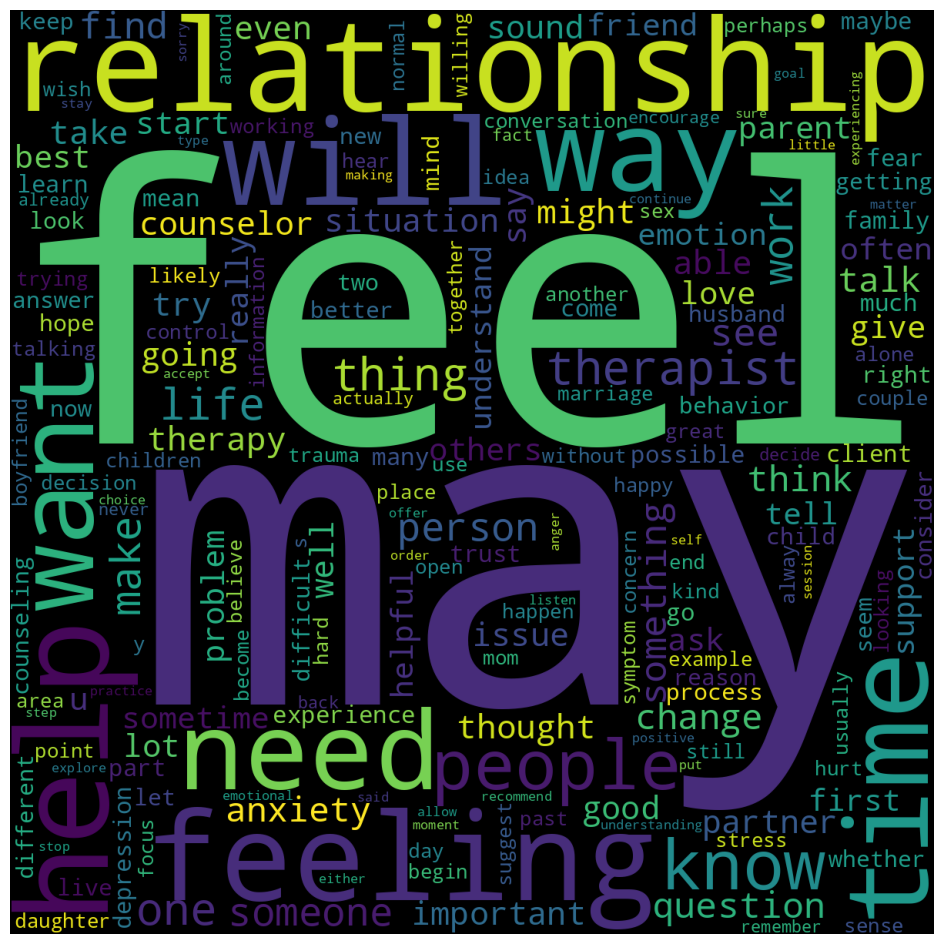

In [3]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from wordcloud import WordCloud
from wordcloud import STOPWORDS

FRACTION = 1.0
subplots(figsize=(12, 12))
text = ' '.join(df.sample(frac=FRACTION, random_state=2023)['Response'].values.tolist())
imshow(X=WordCloud(random_state=2023, height=1200, width=1200, stopwords=STOPWORDS,).generate(text=text), )
axis('off')

This is a relatively small dataset and at first glance it looks fairly uniform. Let's see if our sentence transformer can group similar words near each other based on the response sentences.

In [4]:
%env TOKENIZERS_PARALLELISM=true
! pip install sentence-transformers

env: TOKENIZERS_PARALLELISM=true
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=758aeae2e9b219c853d66d0d176f440e991594926574395adbbcd3fd50b87883
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [5]:
# https://www.kaggle.com/code/ianalyticsgeek/keywords-extraction-using-bert
from arrow import now
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# we can't use more features than we can visualize
MAX_FEATURES = 300

NGRAM_RANGE = (1, 1)
model_start = now()
count = TfidfVectorizer(ngram_range=NGRAM_RANGE, stop_words='english', max_features=MAX_FEATURES).fit(df['Response'])
features = count.get_feature_names_out()
print('{}: got features'.format(now()))
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# we need to encode the essays to get the words' relationships to each other
embedding = model.encode(df['Response'])
print('{}: got embeddings'.format(now()))
feature_embeddings = model.encode(features)
print('{}: got feature embeddings'.format(now()))
print('model time: {}'.format(now() - model_start))

2023-12-03T18:15:46.206004+00:00: got features


Batches:   0%|          | 0/78 [00:00<?, ?it/s]

2023-12-03T18:20:12.515717+00:00: got embeddings


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2023-12-03T18:20:13.973497+00:00: got feature embeddings
model time: 0:04:28.268511


In [6]:
# now we can project the feature vectors into 2-space to visualize 
from pandas import DataFrame
from plotly.express import scatter
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=2023, verbose=1, n_iter=10000)
tsne_df = DataFrame(data=tsne.fit_transform(X=feature_embeddings), columns=['t0', 't1'])
tsne_df['word'] = features
scatter(data_frame=tsne_df, x='t0', y='t1', text='word', height=900, ).update_traces(marker={'size': 1})

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.001s...
[t-SNE] Computed neighbors for 300 samples in 0.182s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 143.134552
[t-SNE] KL divergence after 1500 iterations: 4.187972
